In [ ]:
from tradingview_screener import Query, col
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from mplfinance.original_flavor import candlestick_ohlc

In [119]:
REL_VOLUME = 1.2
RSI_VALUE = 60
PRICE_ABOVE_EMA = True
EMA_CONSTRAINT_DAILY = True
EMA_CONSTRAINT_HOURLY = True
EMA_CONSTRAINT_WEEKLY = False
MACD_CONSTRAINT = True

In [120]:
filters = [
    col('type') == 'stock',
    col('relative_volume_10d_calc') > REL_VOLUME,
    col('RSI') < RSI_VALUE,
    col('exchange') != 'OTC',
]

if MACD_CONSTRAINT:
    # Daily timeframe
    filters += [
        col('MACD.macd') >= col('MACD.signal'),
    ]

if PRICE_ABOVE_EMA:
    # Daily timeframe
    filters += [
        col('close') > col('EMA9'),
        col('close') > col('EMA20'),
        col('close') > col('EMA50'),
        col('close') > col('EMA200'),
    ]

if EMA_CONSTRAINT_DAILY:
    # Daily timeframe
    filters += [
        col('EMA9') > col('EMA20'),
        col('EMA20') > col('EMA50'),
        col('EMA50') > col('EMA200'),
    ]

if EMA_CONSTRAINT_HOURLY:
    # 60-minute timeframe
    filters += [
        col('EMA9|60') > col('EMA20|60'),
        col('EMA20|60') > col('EMA50|60'),
        col('EMA50|60') > col('EMA200|60'),
    ]

if EMA_CONSTRAINT_WEEKLY:
    # Weekly timeframe
    filters += [
        col('EMA9|1W') > col('EMA20|1W'),
        col('EMA20|1W') > col('EMA50|1W'),
        col('EMA50|1W') > col('EMA200|1W'),
    ]

row_count, df = (
    Query()
    .select(
        'name', "close",
        "relative_volume_10d_calc",
        "EMA9", "EMA20", "EMA50", "EMA200",
        "EMA9|60", "EMA20|60", "EMA50|60", "EMA200|60", 
        "EMA9|240", "EMA20|240", "EMA50|240", "EMA200|240", 
        "EMA9|1W", "EMA20|1W", "EMA50|1W", "EMA200|1W", 
        "RSI7", "RSI",
        'change|60', 'change|240', 'change', 'change|1W', 'change|1M',
        'MACD.macd', 'MACD.signal',
        "market_cap_basic",
        "High.1M", "High.3M", "High.6M", "High.All",
        "Low.1M", "Low.3M", "Low.6M", "Low.All",
        'type', 'exchange',
        "Volatility.D",
        "Perf.W", "Perf.1M", "Perf.Y", "Perf.3Y", "Perf.5Y", "Perf.10Y", "Perf.YTD",
        "sector", "price_target_average"
    )
    .where(*filters)
    .order_by('change', ascending=False)
    .offset(5)
    .limit(25)
    .get_scanner_data()
)

# Post-processing
df.rename(columns={"relative_volume_10d_calc": "rel_vol"}, inplace=True)
df["target up/down"] = (((df["price_target_average"] / df["close"]) - 1) * 100).round(2)
df = df.sort_values(by="target up/down", ascending=False)

# Final selection
df[[
    "name", "close", "change", "rel_vol", "Perf.W",
    "Perf.1M", "Perf.Y", "Perf.3Y", "Perf.5Y", "Perf.10Y", "Perf.YTD",
    "Volatility.D", "exchange", "sector", "price_target_average", "target up/down"
]]


,name,close,change,rel_vol,Perf.W,Perf.1M,Perf.Y,Perf.3Y,Perf.5Y,Perf.10Y,Perf.YTD,Volatility.D,exchange,sector,price_target_average,target up/down
6,DHT,11.98,-1.236603,1.369830,6.299911,2.305722,6.583630,114.311270,118.613139,49.004975,26.638478,2.557652,NYSE,Transportation,13.84,15.53
0,UFCS,28.57,0.316011,2.098309,0.351247,0.210452,34.447059,-8.983753,6.011132,-10.579030,-0.626087,2.926657,NASDAQ,Finance,30.00,5.01
1,EFC/PA,25.15,0.199203,1.272527,0.066844,0.850917,2.318959,9.586057,13.033708,-0.984252,0.801603,0.437550,NYSE,Finance,NaN,NaN
2,RWAYL,25.11,0.079713,1.852101,0.399840,0.641283,0.843373,-0.396668,-0.396668,-0.396668,1.148036,0.291633,NASDAQ,Finance,NaN,NaN
3,GAINN,24.90,0.000000,1.967042,0.000000,-0.280336,2.892562,2.132896,-1.347068,-1.503165,1.014199,0.040161,NASDAQ,Miscellaneous,NaN,NaN
4,TECTP,10.60,-0.075415,2.071557,0.444419,1.923077,3.313840,2.812803,27.710843,4.950495,1.942681,0.740741,NASDAQ,Finance,NaN,NaN
5,WSBCP,25.20,-0.118906,1.385272,-0.316456,0.000000,3.278689,-2.702703,-3.262956,-3.262956,-0.395257,0.119048,NASDAQ,Finance,NaN,NaN


In [121]:
def kalman_filter(observations, process_noise=0.001, measurement_noise=0.1):
    """
    Applies a Kalman filter to smooth a time series.
    
    Parameters:
        observations (list/pd.Series): Time series data to filter
        process_noise (float): Variance of process noise (Q)
        measurement_noise (float): Variance of measurement noise (R)
        
    Returns:
        list: Smoothed estimates of the time series
    """
    estimates = []
    estimate = observations[0]  # Initial state estimate
    error_cov = 1.0             # Initial error covariance
    
    for z in observations:
        # Prediction
        prior_estimate = estimate
        prior_error_cov = error_cov + process_noise
        
        # Update (Kalman Gain)
        kalman_gain = prior_error_cov / (prior_error_cov + measurement_noise)
        estimate = prior_estimate + kalman_gain * (z - prior_estimate)
        error_cov = (1 - kalman_gain) * prior_error_cov
        
        estimates.append(estimate)
    
    return estimates

def heikin_ashi(df, smoothing_length=10):
    ha = pd.DataFrame(index=df.index)

    # Raw HA values before smoothing
    ha['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    ha['Open'] = 0.0

    for i in range(len(df)):
        if i == 0:
            ha.iat[0, ha.columns.get_loc('Open')] = df['Open'].iloc[0]
        else:
            ha.iat[i, ha.columns.get_loc('Open')] = (ha['Open'].iloc[i-1] + ha['Close'].iloc[i-1]) / 2

    ha['High'] = ha[['Open', 'Close']].join(df['High']).max(axis=1)
    ha['Low'] = ha[['Open', 'Close']].join(df['Low']).min(axis=1)
    ha['Volume'] = df['Volume']

    # Apply smoothing
    ha['Close'] = ha['Close'].rolling(window=smoothing_length).mean()
    ha['Open'] = ha['Open'].rolling(window=smoothing_length).mean()
    ha['High'] = ha['High'].rolling(window=smoothing_length).mean()
    ha['Low'] = ha['Low'].rolling(window=smoothing_length).mean()

    return ha.dropna()

def calculate_macd(price, fast=12, slow=26, signal=9):
    exp1 = price.ewm(span=fast, adjust=False).mean()
    exp2 = price.ewm(span=slow, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def calculate_rsi(price, period=14):
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [122]:
series = yf.download(df.name.tolist(), interval="1d")
# series = yf.download("QBTS", interval="1d")
series = series[series.index >= "2025-01-01"]
close_prices = series["Close"]
close_prices.dropna(inplace=True, axis=1)

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\2132783342.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  series = yf.download(df.name.tolist(), interval="1d")
[**********************57%**                     ]  4 of 7 completedFailed to get ticker 'EFC/PA' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  7 of 7 completed

1 Failed download:
['EFC/PA']: YFTzMissingError('possibly delisted; no timezone found')
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\2132783342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices.dropna(inplace=True, axis=1)


C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\1895435351.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


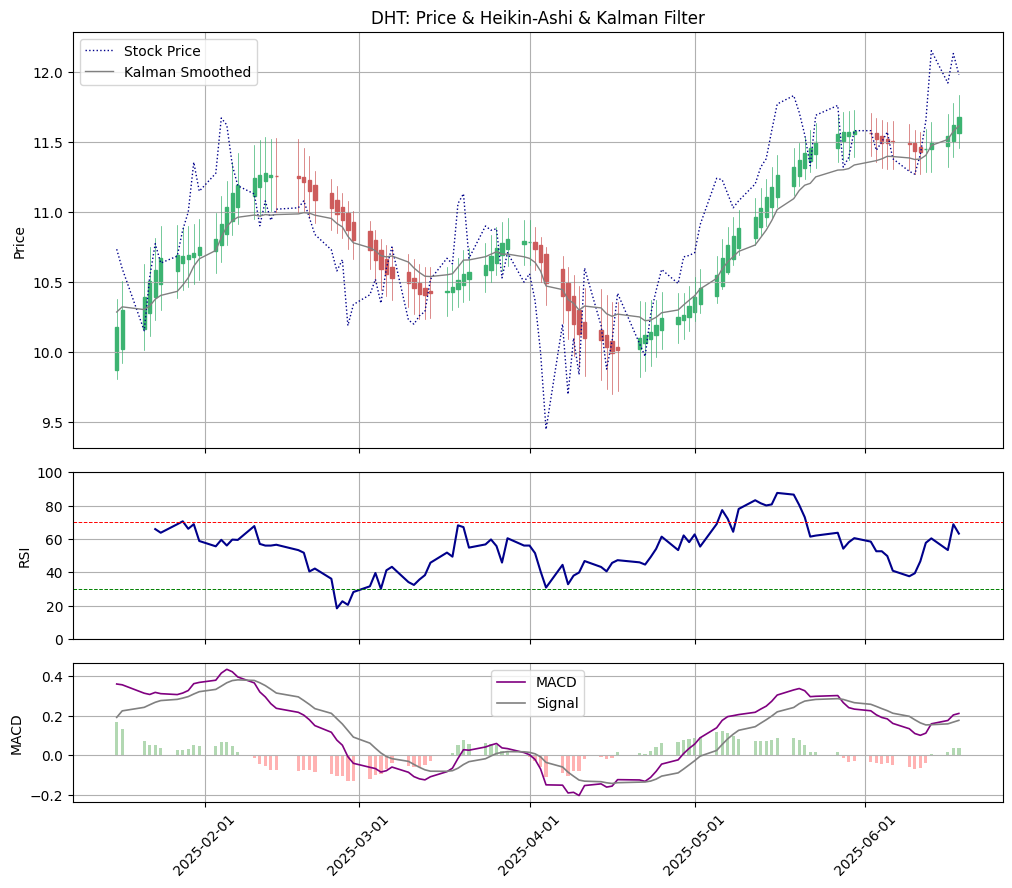

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\1895435351.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


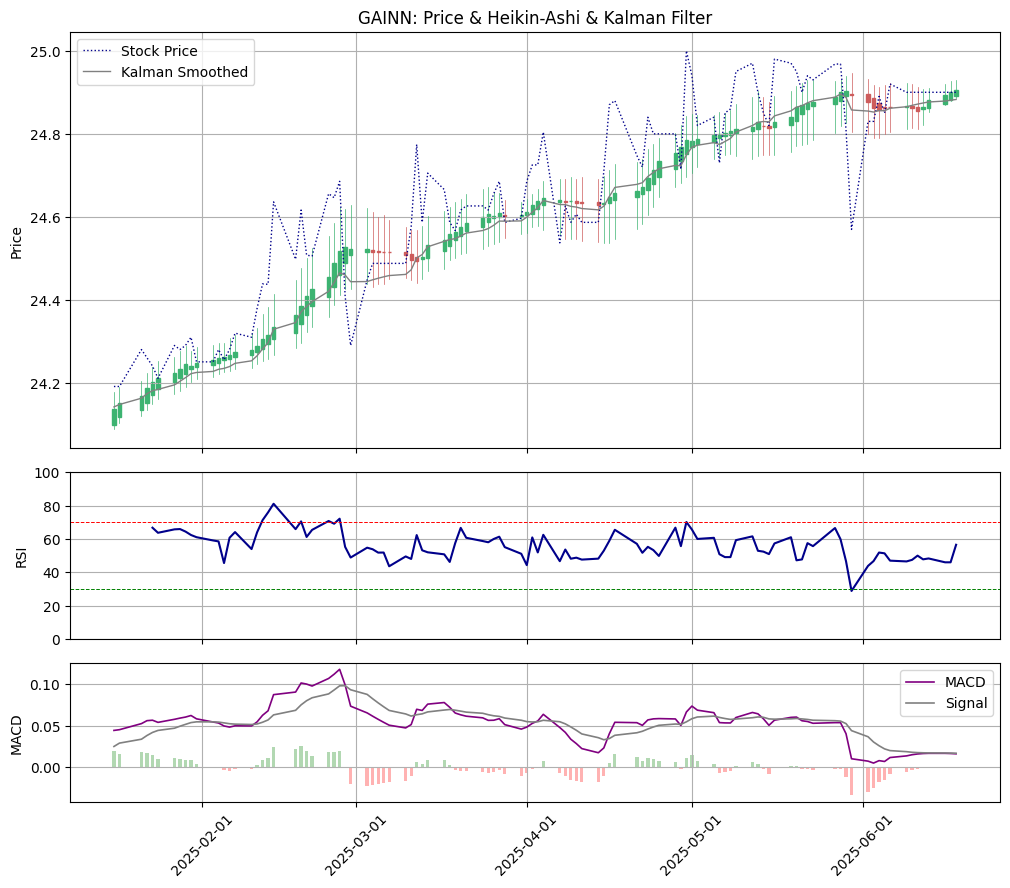

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\1895435351.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


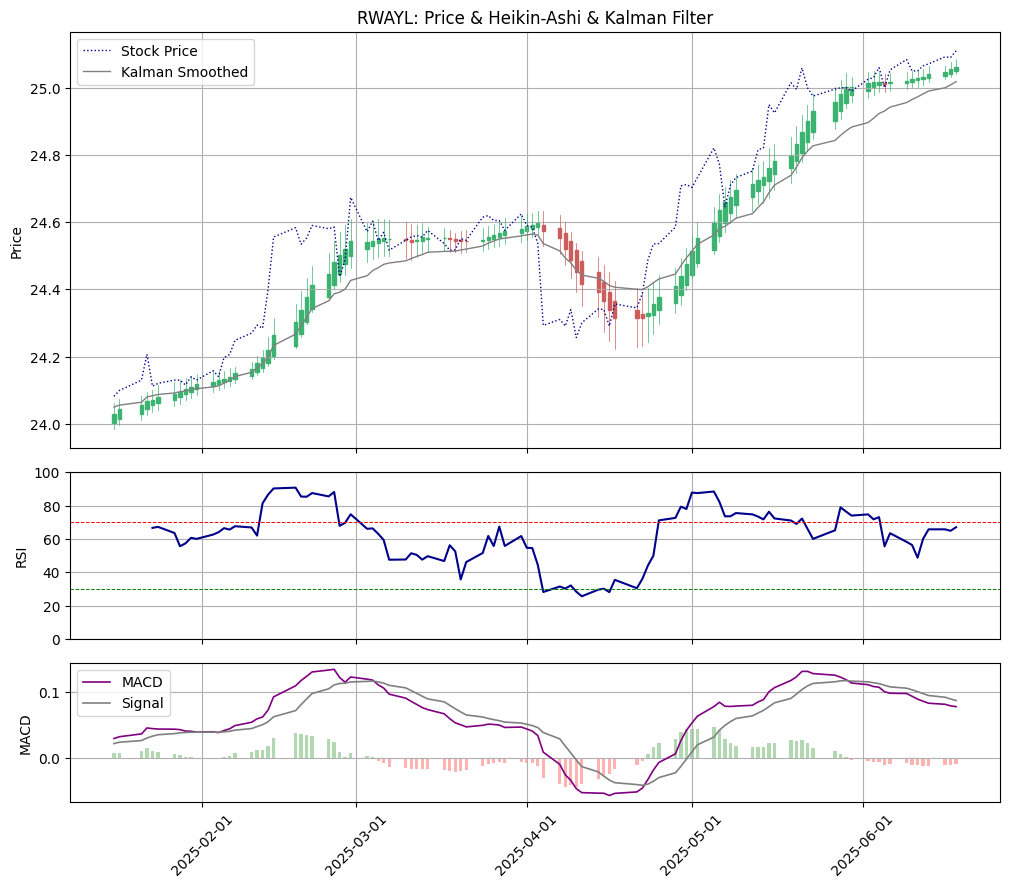

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\1895435351.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


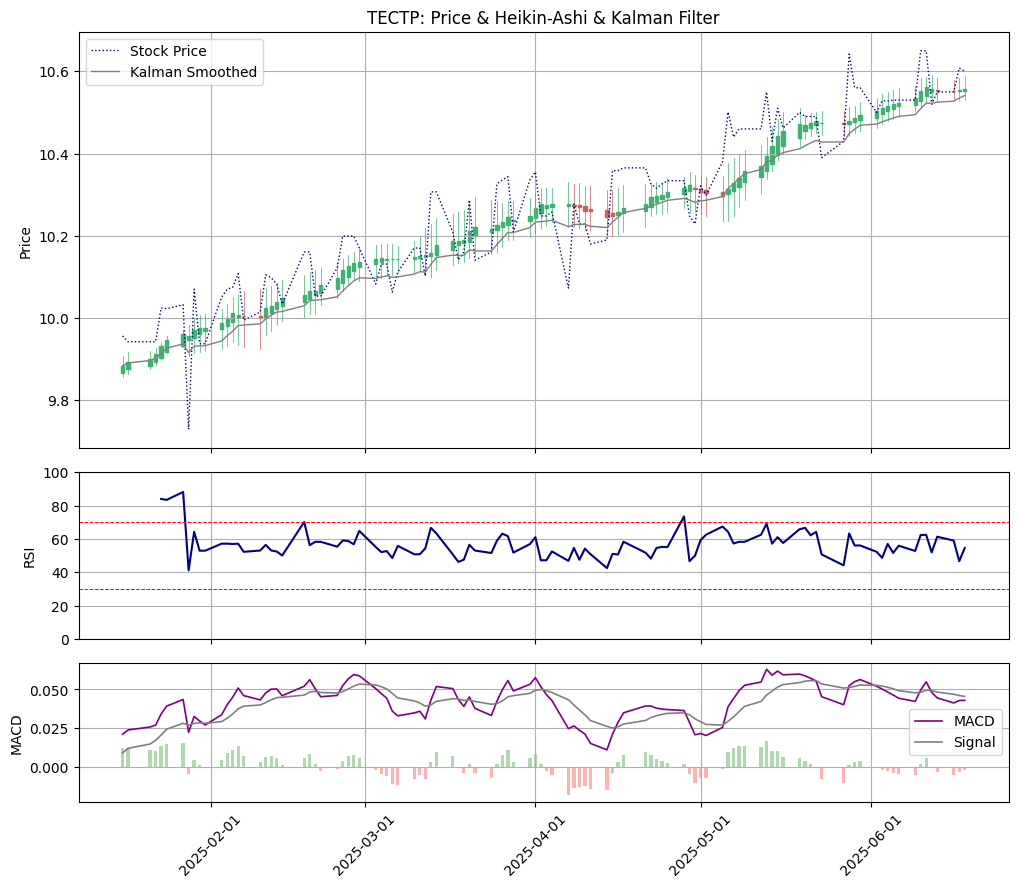

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\1895435351.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


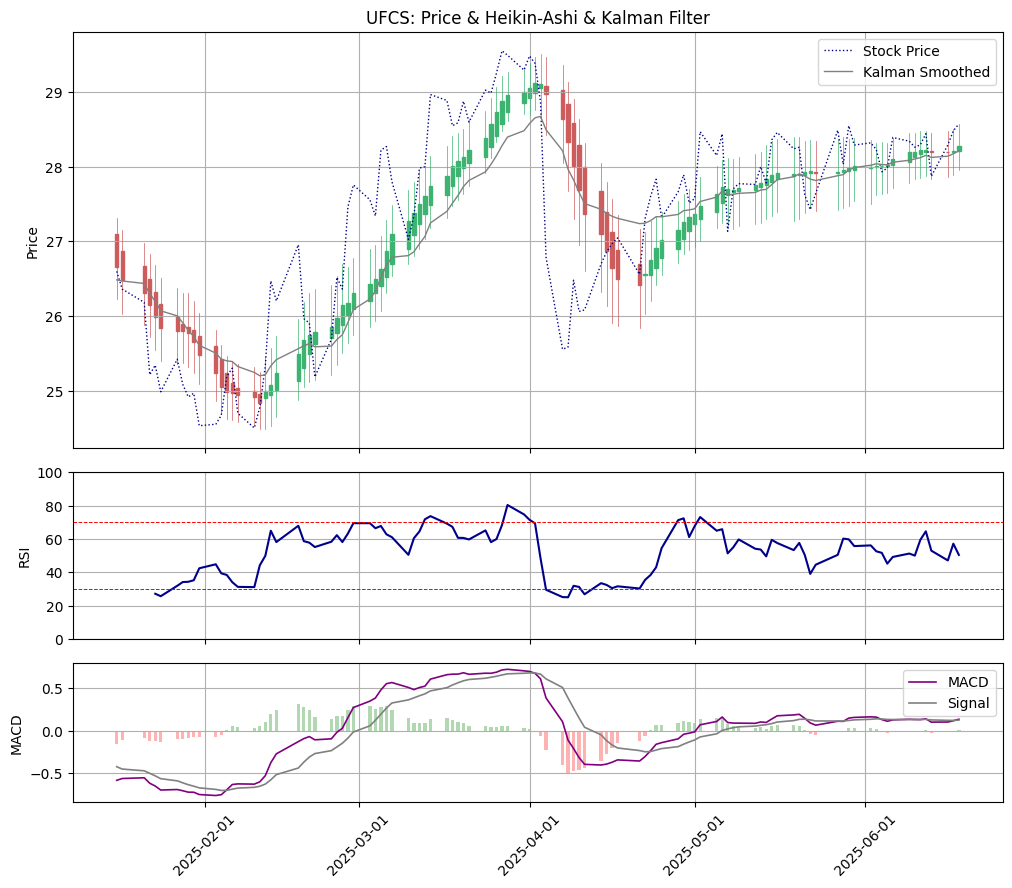

C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\1895435351.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate = observations[0]  # Initial state estimate
C:\Users\bsaurugg\AppData\Local\Temp\ipykernel_4016\156401472.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


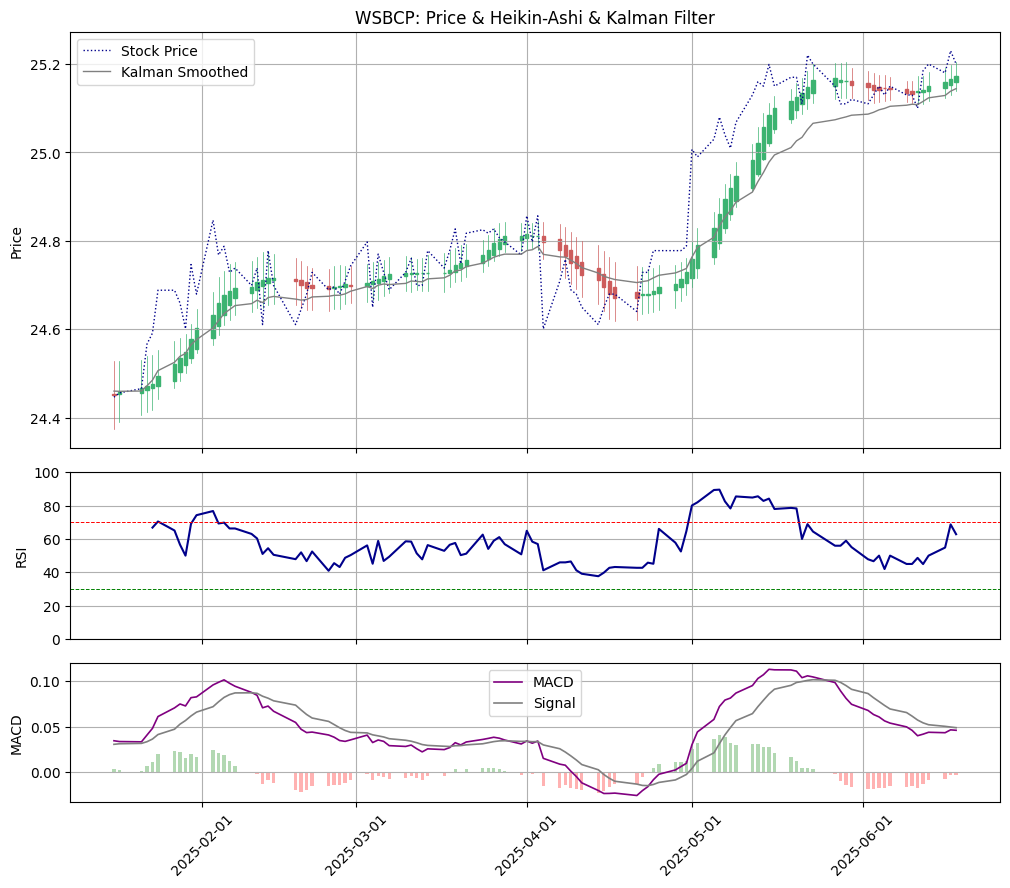

In [124]:
for ticker in close_prices.columns.tolist():
    smoothed = pd.Series(kalman_filter(close_prices[ticker]), index=close_prices[ticker].index)

    df_ticker = series.xs(ticker, axis=1, level=1).dropna()

    # Heikin-Ashi
    df_ha = heikin_ashi(df_ticker)
    df_ha.columns = ['Open', 'Close', 'High', 'Low', 'Volume']
    df_ha = df_ha[['Open', 'High', 'Low', 'Close', 'Volume']]

   # MACD and RSI
    macd_line, signal_line, hist = calculate_macd(close_prices[ticker])
    macd_line, signal_line, hist = calculate_macd(close_prices[ticker])
    macd_line = macd_line.loc[df_ha.index]       # optional
    signal_line = signal_line.loc[df_ha.index]   # optional
    hist = hist.loc[df_ha.index]                 # optional
    rsi = calculate_rsi(close_prices[ticker])
    rsi = rsi.loc[df_ha.index]  # Align RSI with HA chart

    # Prepare OHLC for plotting
    df_ha_ohlc = df_ha.copy()
    df_ha_ohlc['Date'] = mdates.date2num(df_ha_ohlc.index.to_pydatetime())
    df_ha_ohlc = df_ha_ohlc[['Date', 'Open', 'High', 'Low', 'Close']]
    quotes = [tuple(x) for x in df_ha_ohlc.values]
    dates = df_ha.index

    # Create figure with 3 panels: price, macd, rsi
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1.2, 1], hspace=0.1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    # Plot Heikin-Ashi candles
    for quote in quotes:
        color = 'indianred' if quote[4] >= quote[1] else 'mediumseagreen'
        candlestick_ohlc(ax1, [quote], width=0.6, colorup=color, colordown=color)

    # Align with df_ha index
    aligned_close = close_prices[ticker].loc[df_ha.index]
    aligned_smoothed = smoothed.loc[df_ha.index]
    
    # Overlay close and Kalman-smoothed
    
    ax1.plot(dates, aligned_close, color='darkblue', label='Stock Price', linestyle=':', linewidth=1)
    ax1.plot(dates, aligned_smoothed, color='gray', label='Kalman Smoothed', linewidth=1)
    ax1.grid(which='minor', linestyle='-', linewidth=0.25)

    # ax1.plot(dates, close_prices[ticker], color='darkblue', label='Stock Price', linewidth=1)
    # ax1.plot(dates, smoothed, color='gray', label='Kalman Smoothed', linewidth=1)
    ax1.set_title(f"{ticker}: Price & Heikin-Ashi & Kalman Filter")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # RSI Plot
    ax2.plot(dates, rsi, label='RSI', color='darkblue')
    ax2.axhline(70, color='red', linestyle='--', linewidth=0.7)
    ax2.axhline(30, color='green', linestyle='--', linewidth=0.7)
    ax2.set_ylabel("RSI")
    ax2.set_ylim(0, 100)
    ax2.grid(True)

    # MACD Plot
    ax3.plot(dates, macd_line, label='MACD', color='purple', linewidth=1.2)
    ax3.plot(dates, signal_line, label='Signal', color='gray', linewidth=1.2)
    ax3.bar(dates, hist, color=['green' if h >= 0 else 'red' for h in hist], width=0.6, alpha=0.3)
    ax3.set_ylabel("MACD")
    ax3.legend()
    ax3.grid(True)

    # Formatting x-axis
    ax3.xaxis_date()
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
